In [1]:

"""
Initialization
"""
# imports
import os
import pandas as pd
from collections import Counter
import time
from math import log10
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict
from scipy import stats
import matplotlib.ticker as mticker
import numpy as np
from statistics import mean
import re
# constant, data
os.chdir("/Users/antata/Library/CloudStorage/OneDrive-BaylorCollegeofMedicine/text-mining/categories/")
category_names = ["cancer", "cardiovascular", "digestive", "endocrine", "hematological", "immune", "metabolic", "neurological", "obesity", "respiratory", "urogenital"]#, "T2D"]
category_name_to_idx = {c: i for i, c in enumerate(category_names)}
color_template = ['#e6194B','#f58231','#f3c300','#469990','#808000','#2f8e3b','#0db7dd','#4363d8','#800000','#f032e6','#911eb4']#, "#000075"]#'#8298e5'
controls = []
corsiv_probe_df = pd.read_csv("../control/corsiv_all_probes_id.txt", sep="\t", names=["chr", "start", "end", "probeId", "corsiv_start", "corsiv_end", "corsiv_id"])
corsiv_probe_list = set(corsiv_probe_df.iloc[:,3])
for i in range(1, 11):
    control_probe_df = pd.read_csv(f"../control/control_probes_{i}.txt", sep="\t", names=["chr", "start", "end", "probeId", "_", "corsiv_start", "corsiv_end", "corsiv_id"])
    control_probe_list = set(control_probe_df.iloc[:,3])
    controls.append(control_probe_list)
control_probe_df = pd.read_csv("../control/control_all_probes_id.txt", sep="\t", names=["chr", "start", "end", "probeId", "id"])
control_probe_list = set(control_probe_df.iloc[:,3])
epic = pd.read_csv("../humanData/database/EPIC.hg38.txt", sep="\t", header=None)
epic_probe_list = set(epic.iloc[:,3])
hm450 = pd.read_csv("../humanData/database/HM450.hg38.txt", sep="\t", header=None)
hm450_probe_list = set(hm450.iloc[:,3])
illumina = epic_probe_list.union(hm450_probe_list)
enrichment_cutoff = (len(corsiv_probe_list) / len(illumina)*1.5)
enrichment_cutoff
non_corsiv_baseline = illumina - corsiv_probe_list
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 2  # Thicker outer box
plt.rcParams['xtick.major.width'] = 2  # Thicker x-axis ticks
plt.rcParams['ytick.major.width'] = 2  # Thicker y-axis ticks

In [ ]:
# sanity check on three sets of probe's intersection
print(len(corsiv_probe_list), len(illumina), len(control_probe_list))
print(len(corsiv_probe_list.intersection(illumina)))
print(len(corsiv_probe_list.intersection(control_probe_list)))
print(len(illumina.intersection(control_probe_list)))


In [2]:
"""
read all probes if combined file alrdy exists
"""
cat_probes_dict = []

def read_in_probes(input_cat):
    if input_cat == "metabolic":
        df = pd.read_csv(f"probe/metabolic_diseases_all_probes.csv")
    else:
        df = pd.read_csv(f"probe/{input_cat}_all_probes.csv")
    probe_list = df["probeId"].to_list()
    c = dict(Counter(probe_list))
    return c


for cat in category_names:
    start = time.time()
    print(cat)
    c = read_in_probes(cat)
    cat_probes_dict.append(c)
    end = time.time()
    print(f'Time for {cat} code to run: ', end - start)

cancer
Time for cancer code to run:  0.16274595260620117
cardiovascular
Time for cardiovascular code to run:  0.025309324264526367
digestive
Time for digestive code to run:  0.03699803352355957
endocrine
Time for endocrine code to run:  0.03651714324951172
hematological
Time for hematological code to run:  0.023836851119995117
immune
Time for immune code to run:  0.04796099662780762
metabolic
Time for metabolic code to run:  0.05194902420043945
neurological
Time for neurological code to run:  0.1091148853302002
obesity
Time for obesity code to run:  0.019121885299682617
respiratory
Time for respiratory code to run:  0.03347897529602051
urogenital
Time for urogenital code to run:  0.08954071998596191


In [ ]:
cat_probes_dict[0]
for i in range(1, max(cat_probes_dict[0].values())+1):
    c = {k: v for k, v in cat_probes_dict[0].items() if v >= i}
    print(i, len(c))

In [ ]:
study = {"GSE51180":"Cruickshank", "GSE61151":"Flanagan"}
for s in study:
    for t1 in ["iir", "icc"]:
        dfs = []
        for t2 in ["noncorsiv", "corsiv"]:
            df = pd.read_csv(f"iir_icc/{s}_{t2}_{t1}_results.csv", index_col=0)
            dfs.append(df)
        df = pd.concat(dfs, axis=0)
        df.drop_duplicates(subset=["ID"], inplace=True)
        df.to_csv(f"iir_icc/{study[s]}_{t1}_results.csv", index=False)

In [ ]:
# sanity check on background probes
epic_hm450_probe = pd.read_csv("../control/humanData/EPIC_HM450.clean.bed", sep="\t", names=["chr", "start", "end", "probeId"])
s1 = set(epic_hm450_probe["probeId"])
s1 = list(element.split(',') for element in s1)
s1 = set(item for sublist in s1 for item in sublist)
s2 = illumina
s1 == s2


In [ ]:

def generate_plot(dataset, iir_icc, column_to_plot, category_name, baseline, paper_threshold = 2):
    
    if baseline == "Control":
        baseline_dataset = control_probe_list
    elif baseline == "Non-CoRSIV":
        baseline_dataset = illumina
    else:
        raise ValueError("Invalid baseline value")
    
    if iir_icc == "iir":
        bins = np.arange(0, 1.05, 0.05)
    else:
        bins = np.arange(-1.05, 1.05, 0.05)
    disease_probe = cat_probes_dict[category_name_to_idx[category_name]]
    smaller_disease_probe = set({k for k, v in disease_probe.items() if v >= paper_threshold})

    columns_names_for_plot = ["CoRSIV", f"{baseline}", f"CoRSIV {category_name.capitalize()}", f"{baseline} {category_name.capitalize()}", f"CoRSIV {category_name.capitalize()} ≥ {paper_threshold} Papers", f"{baseline} {category_name.capitalize()} ≥ {paper_threshold} Papers"]
    df = pd.read_csv(f"iir_icc/{dataset}_{iir_icc}_results.csv")
    dfs_for_plot = [df[df["ID"].isin(corsiv_probe_list)], #corsiv
                        df[(~df["ID"].isin(corsiv_probe_list)) & df["ID"].isin(baseline_dataset)], #noncorsiv / control
                        df[df["ID"].isin(corsiv_probe_list) & df["ID"].isin(disease_probe)], #corsiv disease
                        df[(~df["ID"].isin(corsiv_probe_list)) & df["ID"].isin(disease_probe) & df["ID"].isin(baseline_dataset)], #noncorsiv/control disease
                        df[df["ID"].isin(corsiv_probe_list) & df["ID"].isin(smaller_disease_probe)], #corsiv disease ≥ 2
                        df[(~df["ID"].isin(corsiv_probe_list)) & df["ID"].isin(smaller_disease_probe) & df["ID"].isin(baseline_dataset)], #noncorsiv/control disease ≥ 2
                        ]
    # Define line styles and colors
    line_styles = ['-', ':', '-', ':', '-', ':']
    colors = ['grey', 'grey', 'black', 'black', color_template[category_name_to_idx[category_name]], color_template[category_name_to_idx[category_name]]]

    plt.figure(figsize=(10, 6))

    for i, (df_subset, label) in enumerate(zip(dfs_for_plot, columns_names_for_plot)):
        number = len(set(df_subset["ID"]))
        median = df_subset[column_to_plot].median()
        counts, _ = np.histogram(df_subset[column_to_plot], bins=bins)
        total_count = np.sum(counts)
        percentages = (counts / total_count) * 100
        plt.plot(bins[:-1], percentages, linewidth=2, label=f"{label} (n={number:,}, median={median:.2f})", color=colors[i], linestyle=line_styles[i])
    plt.xlabel(f"{column_to_plot} values")
    plt.ylabel("Percentage (%)")
    plt.title(f"{s} - {column_to_plot} - {category_name.capitalize()}")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()
generate_plot("Cruickshank", "icc", "ICC", "neurological", "Control")

In [ ]:

def generate_plot_all_categories(dataset, iir_icc, column_to_plot, baseline, paper_threshold = 2, step_size = 0.05, output = False, show = False):
    
    if baseline == "Control":
        baseline_dataset = control_probe_list
    elif baseline == "Non-CoRSIV":
        baseline_dataset = non_corsiv_baseline
    else:
        raise ValueError("Invalid baseline value")
    
        
    df = pd.read_csv(f"iir_icc/{dataset}_{iir_icc}_results.csv")
    
    fig, axs = plt.subplots(6, 2, figsize=(20, 30))
    axs = axs.flatten()
    axs[-1].axis('off')  # Turn off the last subplot
    axs = axs[:-1]  # Remove the last subplot from the list
    line_styles = ['-', ':', '-', ':', '-', ':']
    if iir_icc == "iir":
        bins = np.arange(0, 1+step_size, step_size)
    else:
        bins = np.arange(-1, 1+step_size, step_size)
        
    for j, category_name in enumerate(category_names):
        ax = axs[j]

        columns_names_for_plot = ["CoRSIV", f"{baseline}", f"CoRSIV {category_name.capitalize()}", f"{baseline} {category_name.capitalize()}"]
        dfs_for_plot = [df[df["ID"].isin(corsiv_probe_list)], #corsiv
                            df[df["ID"].isin(baseline_dataset)], #noncorsiv / control
                            df[df["ID"].isin(corsiv_probe_list) & df["ID"].isin(cat_probes_dict[j])], #corsiv disease
                            df[df["ID"].isin(baseline_dataset) & df["ID"].isin(cat_probes_dict[j])], #noncorsiv/control disease
                        ]
        pset = []
        for pidx in range(2, paper_threshold+1):
            p2 = set({k for k, v in cat_probes_dict[j].items() if v >= pidx})
            pset.append(p2)
        for k, p in enumerate(pset):
            dfs_for_plot.append(df[df["ID"].isin(p)& df["ID"].isin(corsiv_probe_list)])
            dfs_for_plot.append(df[df["ID"].isin(p)& df["ID"].isin(baseline_dataset)])
            columns_names_for_plot.append(f"CoRSIV {category_name.capitalize()} ≥ {pidx} Papers")
            columns_names_for_plot.append(f"{baseline} {category_name.capitalize()} ≥ {pidx} Papers")

            
        # Define line styles and colors
        colors = ['grey', 'grey', 'black', 'black', color_template[category_name_to_idx[category_name]], color_template[category_name_to_idx[category_name]]]

        for i, (df_subset, label) in enumerate(zip(dfs_for_plot, columns_names_for_plot)):
            number = len(set(df_subset["ID"]))
            median = df_subset[column_to_plot].median()
            counts, _ = np.histogram(df_subset[column_to_plot], bins=bins)
            total_count = np.sum(counts)
            percentages = (counts / total_count) * 100
            ax.plot(bins[:-1], percentages, linewidth=2, label=f"{label} (n={number:,}, median={median:.2f})", color=colors[i], linestyle=line_styles[i])
        ax.set_xlabel(f"{column_to_plot} values")
        ax.set_ylabel("Percentage (%)")
        ax.set_title(category_name.capitalize())
        if iir_icc == "iir":
            ax.legend(bbox_to_anchor=(1, 1), loc='upper right', frameon=False, fontsize=10)
        else:
            ax.legend(bbox_to_anchor=(0, 1), loc='upper left', frameon=False, fontsize=10)
    plt.suptitle(f"{dataset} - {column_to_plot}", y=1, fontsize=16)
    plt.tight_layout()
    if output:
        plt.savefig(f"/Users/antata/Desktop/text-mining-figures/iir_icc/{dataset}_{column_to_plot}_{baseline}_{step_size}.pdf", format="pdf")
    if show:
        plt.show()
counters = 0
colname_type = [("iir1", "iir"), ("iir2", "iir"), ("ICC", "icc")]
for baseline in ["Control", "Non-CoRSIV"]:
    if baseline == "Control":
        continue
    for d in ["Cruickshank", "Flanagan"]:
        for colname, t in colname_type:
            generate_plot_all_categories(d, t, colname, baseline, step_size=0.05, show=True)
            counters += 1
print(counters)

In [ ]:

def generate_plot_all_categories(dataset, iir_icc, column_to_plot, baseline, paper_threshold = 2, step_size = 0.05, output = False, show = False):
    
    if baseline == "Control":
        baseline_dataset = control_probe_list
    elif baseline == "Non-CoRSIV":
        baseline_dataset = non_corsiv_baseline
    else:
        raise ValueError("Invalid baseline value")
    
        
    df = pd.read_csv(f"iir_icc/{dataset}_{iir_icc}_results.csv")
    
    fig, axs = plt.subplots(6, 2, figsize=(20, 30))
    axs = axs.flatten()
    axs[-1].axis('off')  # Turn off the last subplot
    axs = axs[:-1]  # Remove the last subplot from the list
    line_styles = ['-', ':', '-', ':', '-', ':']
    if iir_icc == "iir":
        bins = np.arange(0, 1+step_size, step_size)
    else:
        bins = np.arange(-1, 1+step_size, step_size)
        
    for j, category_name in enumerate(category_names):
        ax = axs[j]

        columns_names_for_plot = []
        dfs_for_plot = []
        pset = []
        for pidx in range(2, paper_threshold+1):
            p2 = set({k for k, v in cat_probes_dict[j].items() if v >= pidx})
            pset.append(p2)
        for k, p in enumerate(pset):
            dfs_for_plot.append(df[df["ID"].isin(p)& df["ID"].isin(corsiv_probe_list)])
            dfs_for_plot.append(df[df["ID"].isin(p)& df["ID"].isin(baseline_dataset)])
            columns_names_for_plot.append(f"CoRSIV  ≥ {k+2} Papers")
            columns_names_for_plot.append(f"{baseline} ≥ {k+2} Papers")

            
        # Define line styles and colors
        colors = ['grey', 'grey', 'black', 'black', color_template[category_name_to_idx[category_name]], color_template[category_name_to_idx[category_name]]]

        for i, (df_subset, label) in enumerate(zip(dfs_for_plot, columns_names_for_plot)):
            number = len(set(df_subset["ID"]))
            median = df_subset[column_to_plot].median()
            counts, _ = np.histogram(df_subset[column_to_plot], bins=bins)
            total_count = np.sum(counts)
            percentages = (counts / total_count) * 100
            ax.plot(bins[:-1], percentages, linewidth=2, label=f"{label} (n={number:,}, median={median:.2f})", color=colors[i], linestyle=line_styles[i])
        ax.set_xlabel(f"{column_to_plot} values")
        ax.set_ylabel("Percentage (%)")
        ax.set_title(category_name.capitalize())
        ax.legend(bbox_to_anchor=(0, 1), loc='upper left', frameon=False, fontsize=10)
    plt.suptitle(f"{dataset} - {column_to_plot}", y=1, fontsize=16)
    plt.tight_layout()
    if output:
        plt.savefig(f"/Users/antata/Desktop/text-mining-figures/iir_icc/{dataset}_{column_to_plot}_{baseline}_{step_size}_sensitivity.pdf", format="pdf")
    if show:
        plt.show()
counters = 0
colname_type = [("iir1", "iir"), ("iir2", "iir"), ("ICC", "icc")]
for baseline in ["Control", "Non-CoRSIV"]:
    for d in ["Cruickshank", "Flanagan"]:
        for colname, t in colname_type:
            generate_plot_all_categories(d, t, colname, baseline, paper_threshold=4, step_size=0.05, output=True)
            counters += 1
print(counters)

In [4]:
def get_median_df(dataset, output=False):
    regions = list(zip(["CoRSIV", "Control", "Non-CoRSIV"], [corsiv_probe_list, control_probe_list, non_corsiv_baseline]))
    icc = pd.read_csv(f"iir_icc/{dataset}_icc_results.csv")
    iir = pd.read_csv(f"iir_icc/{dataset}_iir_results.csv")
    m = pd.merge(icc[["ID", "ICC"]], iir[["ID", "iir1", "iir2"]], on="ID", how="inner")
    m[["ICC", "iir1", "iir2"]] = m[["ICC", "iir1", "iir2"]].round(3)
    
    data = []
    for i, catname in enumerate(category_names):
        max_papers = max(cat_probes_dict[i].values())
        for pidx in range(1, max_papers + 1):
            p = set(k for k, v in cat_probes_dict[i].items() if v >= pidx)
            skip = False
            for rname, rset in regions:
                probes_in_region = rset.intersection(p)
                filtered_df = m[m["ID"].isin(probes_in_region)]
                if rname == "CoRSIV" and len(filtered_df) < 15:
                    skip = True
                    break
                medians = {col: filtered_df[col].median() for col in m.columns[1:]}
                data.append({
                    "region_type": rname,
                    "category": catname,
                    "papers": pidx,
                    "Median ICC": medians["ICC"],
                    "Median iir1": medians["iir1"],
                    "Median iir2": medians["iir2"],
                    "Number of Probes": len(filtered_df)
                })
            if skip:
                break
    for rname, rset in regions:
        print(1)
        filtered_df = m[m["ID"].isin(rset)]
        medians = {col: filtered_df[col].median() for col in m.columns[1:]}
        data.append({
            "region_type": rname,
            "category": np.nan,
            "papers": np.nan,
            "Median ICC": medians["ICC"],
            "Median iir1": medians["iir1"],
            "Median iir2": medians["iir2"],
            "Number of Probes": len(filtered_df)
        })

    df = pd.DataFrame(data)
    print(f"DataFrame shape: {df.shape}")
    
    if output:
        df.to_csv(f"iir_icc/{dataset}_median_15_probes_minimum_df_0107.csv", index=False)
    return df

for d in ["Flanagan"]:
    get_median_df(d, output=True)

1
1
1
DataFrame shape: (117, 7)


/var/folders/9p/4j0cmzvj4wbdfnfx78_t44ww0000gp/T/ipykernel_76388/1969106521.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


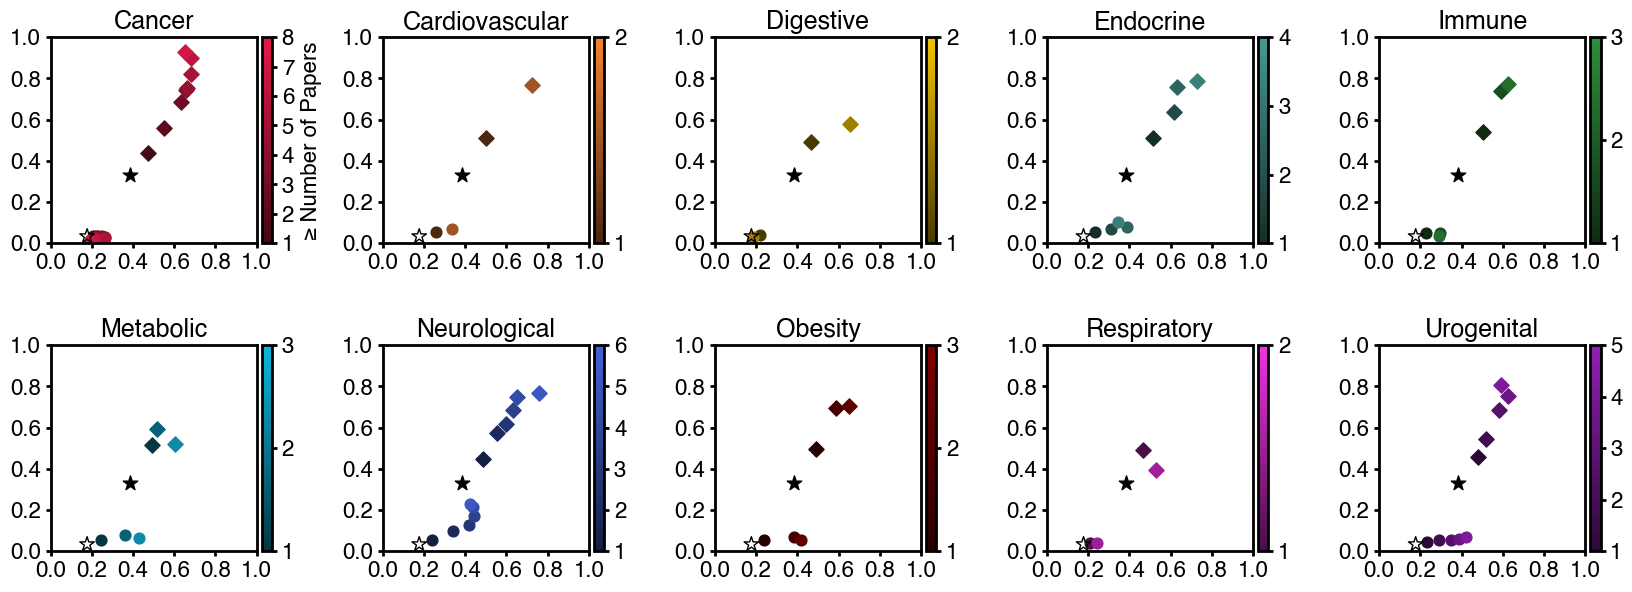

/var/folders/9p/4j0cmzvj4wbdfnfx78_t44ww0000gp/T/ipykernel_76388/1969106521.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


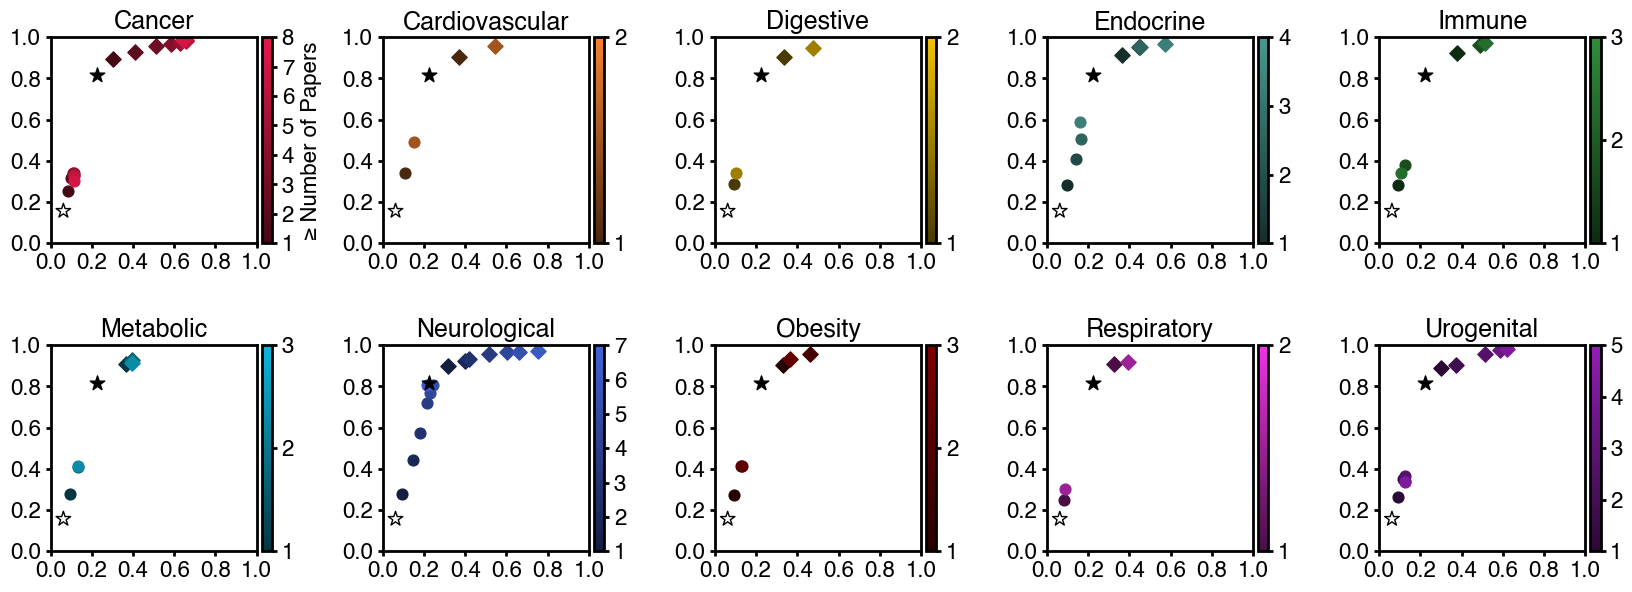

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_median_scatter(data, col1, col2, ax, category, cmap, min_papers, max_papers, show_legend=False):
    region_markers = {"CoRSIV": "D", "Non-CoRSIV": "o"}
    
    for region_type, marker in region_markers.items():
        region_df = df[(df["region_type"] == region_type) & (df["category"] == category)]
        
        for _, row in region_df.iterrows():
            papers = row["papers"]
            color_intensity = (papers - min_papers) / (max_papers - min_papers+1)
            color = cmap(color_intensity)
            ax.scatter(row[col1], row[col2], c=[color], s=60, alpha=1, marker=marker)
    
    # Add black star for all CoRSIVs
    all_corsiv = df[(df["region_type"] == "CoRSIV") & (df["category"].isna())]
    ax.scatter(all_corsiv[col1], all_corsiv[col2], c='black', s=120, marker='*')
    
    # Add hollow black star for all Non-CoRSIVs
    all_non_corsiv = df[(df["region_type"] == "Non-CoRSIV") & (df["category"].isna())]
    ax.scatter(all_non_corsiv[col1], all_non_corsiv[col2], facecolors='none', edgecolors='black', s=120, marker='*')
    
    # ax.set_xlabel("Median IIR$_{2-98}$ at time 1", fontsize=16)
    # ax.set_ylabel("Median ICC", fontsize=16)

    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.set_aspect('equal')  # Make the subplot square
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_papers, vmax=max_papers))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)
    # cbar.ax.tick_params(width=1)  # Thicker colorbar ticks
    if category == "cancer":
        cbar.set_label(f'≥ Number of Papers', rotation=90, labelpad=5, fontsize=16)
    cbar.set_ticks(np.arange(int(min_papers), int(max_papers)+1, 1))
    cbar.set_ticklabels(np.arange(int(min_papers), int(max_papers)+1, 1), fontsize=16)
    
    if show_legend:
        # Create legend for region types
        legend_elements = [plt.Line2D([0], [0], marker=marker, color='gray', label=region, markersize=8, linestyle='None')
                            for region, marker in region_markers.items()]
        legend_elements.extend([
            plt.Line2D([0], [0], marker='*', color='black', label='All CoRSIVs', markersize=8, linestyle='None'),
            plt.Line2D([0], [0], marker='*', markerfacecolor='none', markeredgecolor='black', label='All Non-CoRSIVs', markersize=8, linestyle='None')
        ])

plot_categories = ["cancer", "cardiovascular", "digestive", "endocrine", "immune", "metabolic", "neurological", "obesity", "respiratory", "urogenital"]#, "T2D"]
plot_colors = ['#e6194B','#f58231','#f3c300','#469990','#2f8e3b','#0db7dd','#4363d8','#800000','#f032e6','#911eb4']#, "#000075"]#'#8298e5'

category_names = plot_categories
color_template = plot_colors
for data in ["Cruickshank", "Flanagan"]:
    fig, axes = plt.subplots(2, 5, figsize=(20, 7), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1], 'wspace': 0.5, 'hspace': 0.1})
    # fig.suptitle(data, fontsize=28, y=0.97)


    df = pd.read_csv(f"iir_icc/{data}_median_10_probes_minimum_df.csv")
    # Get min and max papers for each category
    category_paper_ranges = {}
    for category in category_names:
        category_df = df[df["category"] == category]
        category_paper_ranges[category] = (category_df["papers"].min(), category_df["papers"].max())

    for i, category in enumerate(category_names):  # Limit to 11 categories
        row = i // 5
        col = i % 5
        
        # Create color map for this category
        base_color = color_template[i]
        light_color = tuple(c for c in matplotlib.colors.to_rgb(base_color))  # 100% of base color
        dark_color = tuple(0.3 * c for c in matplotlib.colors.to_rgb(base_color))  # 50% of base color (grey instead of black)
        
        # Get min and max papers for this category
        min_papers, max_papers = category_paper_ranges[category]
        
        cmap = LinearSegmentedColormap.from_list('custom', [dark_color, light_color], N=100)
        
        # Plot iir1 vs ICC
        ax = axes[row, col]
        plot_median_scatter(data, "Median iir1", "Median ICC", ax, category, cmap, min_papers, max_papers, show_legend=(i==0))
        ax.set_title(category.capitalize(), fontsize=18)

    # Mute last subplot
    # Create legend for region types and categories
    legend_elements = [plt.Line2D([0], [0], marker=marker, color='gray', label=region, markersize=10, linestyle='None')
                       for region, marker in {"CoRSIV": "D", "Non-CoRSIV": "o"}.items()]
    legend_elements.extend([
        plt.Line2D([0], [0], marker='*', color='black', label='All CoRSIVs', markersize=12, linestyle='None'),
        plt.Line2D([0], [0], marker='*', markerfacecolor='none', markeredgecolor='black', label='All Non-CoRSIVs', markersize=12, linestyle='None')
    ])

    # Create a new figure for the legend
    legend_fig, legend_ax = plt.subplots(figsize=(3, 2))
    legend_ax.axis('off')
    legend = legend_ax.legend(handles=legend_elements, loc='center', fontsize=14, ncol=1, frameon=False)

    # Save the legend as a standalone figure
    legend_output = f"/Users/antata/Desktop/text-mining-figures/Fig5/{data}_legend.svg"
    legend_fig.savefig(legend_output, format="svg", bbox_inches='tight', pad_inches=0.1)
    plt.close(legend_fig)


# Adjust plot style for thicker outer box and ticks
    # plt.rcParams['axes.linewidth'] = 1  # Thicker outer box
    # plt.rcParams['xtick.major.width'] = 1  # Thicker x-axis ticks
    # plt.rcParams['ytick.major.width'] = 1  # Thicker y-axis ticks
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the main title
    # output = f"/Users/antata/Desktop/text-mining-figures/Fig5/{data}_median_scatter_10_probes_minimum_iir1_vs_icc.svg"
    # plt.savefig(output, format="svg")
    plt.show()
    

In [284]:
plt.rcParams['axes.linewidth'] = 1  # Thicker outer box
plt.rcParams['xtick.major.width'] = 1  # Thicker x-axis ticks
plt.rcParams['ytick.major.width'] = 1  # Thicker y-axis ticks

In [ ]:
import matplotlib.pyplot as plt

def plot_median_scatter(dataset, col1, col2, region1, region2, ax):
    df = pd.read_csv(f"iir_icc/{dataset}_median_df.csv")
    df1 = df[(df["region_type"] == region1) & (df["papers"] == 1)]  # solid, colored, square
    df2 = df[(df["region_type"] == region2) & (df["papers"] == 1)]  # hollow, colored, square
    df3 = df[(df["region_type"] == region1) & (df["papers"] == 2)]  # solid, colored, triangle
    df4 = df[(df["region_type"] == region2) & (df["papers"] == 2)]  # hollow, colored, triangle
    df5 = df[(df["region_type"] == region1) & (df["papers"].isna())]  # solid, black, star
    df6 = df[(df["region_type"] == region2) & (df["papers"].isna())]  # hollow, black, star
    df7 = df[(df["region_type"] == region1) & (df["papers"] == 3)]  # solid, colored, circle
    df8 = df[(df["region_type"] == region2) & (df["papers"] == 3)]  # hollow, colored, circle

    marker_list = []
    facecolors_list = []
    labels = [f"{region1} ≥ 1 paper", f"{region2} ≥ 1 paper", f"{region1} ≥ 2 papers", f"{region2} ≥ 2 papers", f"{region1} ≥ 3 papers", f"{region2} ≥ 3 papers", f"All {region1}", f"All {region2}",]
    for i, df_subset in enumerate([df1, df2, df3, df4, df7, df8]):
        if i < 2:
            marker = "s"
        elif i < 4:
            marker = "^"
        else:
            marker = "o"
        for j, category in enumerate(category_names):
            subset = df_subset[df_subset['category'] == category]
            color = color_template[j]
            facecolors = color if i % 2 == 0 else 'none'  # solid for df1, df3; hollow for df2, df4
            ax.scatter(subset[col1], subset[col2], 
                        marker=marker, facecolors=facecolors, edgecolors=color)
        marker_list.append(marker)
        facecolors_list.append("black" if i % 2 == 0 else "none")

    ax.scatter(df5[col1], df5[col2], marker='*', color='black')
    ax.scatter(df6[col1], df6[col2], marker='*', facecolors='none', edgecolors='black')
    marker_list += ['*', '*']
    facecolors_list += ['black', 'none']

    ax.set_xlabel(f"{col1}")
    ax.set_ylabel(f"{col2}")
    ax.set_title(f"{region1} vs {region2}")
    legend_elements = [plt.Line2D([0], [0], marker=marker_list[i], markerfacecolor=facecolors_list[i], color='none', markeredgecolor='black', label=labels[i], markersize=10) for i in range(len(labels))]

    ax.legend(handles=legend_elements, bbox_to_anchor=(0, 1), loc='upper left', frameon=False)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

def plot_all_comparisons(dataset, output = False):
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))
    fig.suptitle(f"{dataset}", fontsize=20, y=0.95)
    comparisons = [
        ("CoRSIV", "Control"),
        ("CoRSIV", "Non-CoRSIV"),
        ("Control", "Non-CoRSIV")
    ]
    
    metrics = [
        ("Median IIR1", "Median ICC"),
        ("Median IIR2", "Median ICC"),
        ("Median IIR1", "Median IIR2")
    ]
    
    for i, (region1, region2) in enumerate(comparisons):
        for j, (col1, col2) in enumerate(metrics):
            plot_median_scatter(dataset, col1, col2, region1, region2, ax=axs[i, j])
            # if j > 0:
            #     axs[i, j].legend().remove()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if output:
        plt.savefig(f"/Users/antata/Desktop/text-mining-figures/iir_icc/{dataset}_median_scatter.pdf", format="pdf")
    else:
        plt.show()

# Plot for both datasets
for dataset in ["Cruickshank", "Flanagan"]:
    plot_all_comparisons(dataset, output=True)

In [ ]:
legend_label = [c.capitalize() for c in category_names]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_template[i], markersize=10, label=legend_label[i]) for i in range(11)]
fig, ax = plt.subplots(figsize=(.08, 1))
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), loc='upper left', frameon=False, ncol=3)
ax.axis('off')
plt.savefig("/Users/antata/Desktop/text-mining-figures/legend.pdf", format="pdf")
